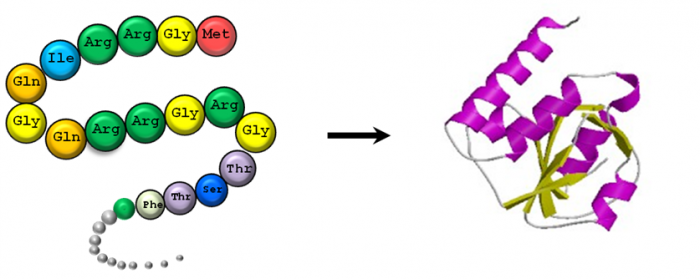

This notebook attempts to understand the structure of the [CAFA 5 Protein Function Prediction](https://www.kaggle.com/competitions/cafa-5-protein-function-prediction/overview) Data and perform **Data Processing** to train a **Deep Neural Network** for the given task.

# Table of Contents

- [Introduction](#Introduction)
- [Understanding the Data](#Understanding-the-Data)
- [Exploring the Data](#Exploring-the-Data)
- [Preparing the Data](#Preparing-the-Data)
- [Building and Training the DNN model](#Building-and-Training-the-DNN-model)
- [Conclusion](#Conclusion)

<div style="border-radius: 10px; background-color: #0077B6">
    <h1 style="color: white; padding: 1rem">Introduction</h1>
</div>

<br>

Basically, [CAFA 5 Protein](https://www.kaggle.com/competitions/cafa-5-protein-function-prediction/overview) dataset is built for predicting/classifying the different *functions* of various **protein sequences**. Before we build a DNN model though, we need to understand the underlying data and it's structure then finally process it to make it ready to be used by the DNN models.

Let us get a basic understanding of what the data means.

<div style="border-radius: 10px; background-color: #0077B6">
    <h1 style="color: white; padding: 1rem">Understanding the Data</h1>
</div>

<br>

Each protein in this dataset is essentially made of a very long chain of amino acids linked together. Biologically. For representing the protein sequence, the individual amino acid is given a one-letter or three-letter code. Thus a protein sequence, it is written down as a long string of characters.

The file `train_sequences.fasta` contains all the string representations of the proteins observed, along with their metadata.

> The `train_sequences.fasta` file will indicate from which database the sequence originate. For example, `sp|P9WHI7|RECN_MYCT` in the FASTA header indicates the protein with UniProt ID `P9WHI7` and gene name `RECN_MYCT` was taken from Swiss-Prot (sp). Any sequences taken from `TrEMBL` will have tr in the header instead of sp. Swiss-Prot and TrEMBL are both parts of UniProtKB.

## Protein functions

A protein's *function* is defined by **Gene Ontology (GO)**. Gene Ontology describes the functions (biologically) in three domains:

- **Biological Process (BPO)**
- **Molecular Function (MF)**
- **Cellular Component (CC)**

The file `train_terms.tsv` contains information about the *functions* (GO terms) of a particular protein. It has three columns:

- `EntryID`: The unique protein id (UniProt ID)
- `term`: The GO term that protein contains
- `aspect`: The domain of the GO term

Since each protein can have multiple GO terms associated with it, our task falls under **Multi-Label Classification**.

**<span style="color: darkblue">The labels for our task will be the GO terms.</span>**

In [100]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Protein Embeddings

In order to train a machine learning model, it is not possible to directly use the protein sequences listed in `train_sequences.fasta` in their alphabetical form. They need to be transformed into a vector representation. We will utilize protein sequence embeddings to train the model. Protein embeddings can be compared to word embeddings that are employed in training NLP models. One approach involves training a customized model to acquire the protein embeddings for the protein sequences within the dataset used in this notebook. Since the dataset represents proteins using amino-acid sequences, which is a conventional method, we can utilize any publicly available pre-trained protein embedding models to generate the embeddings.

Embeddings to be used: [Sergei Fironov's T5 Embeds](https://www.kaggle.com/datasets/sergeifironov/t5embeds)

<div style="border-radius: 10px; background-color: #0077B6">
    <h1 style="color: white; padding: 1rem">Exploring the Data</h1>
</div>

The file `go-basic.obo` contains the information about the GO terms. It is in the form of a **Directed Acyclic Graph (DAG)**.

In [101]:
# basic imports
import numpy as np
import pandas as pd

In [102]:
!pip install obonet

DEPRECATION: pytorch-lightning 1.5.4 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


We will use the Python library `obonet` to read the DAG file.

In [103]:
import obonet as obo

In [104]:
go_graph = obo.read_obo("kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo")
go_graph

In [105]:
print("Nodes in the GO graph: ", len(go_graph))
print("Edges in the GO graph: ", go_graph.number_of_edges())

Nodes in the GO graph:  43248
Edges in the GO graph:  84805


The **Ontology Graph Structure** has around $43,000$ nodes and $84,800$ edges.

> GO is a directed acyclic graph. The nodes in this graph are functional descriptors (terms or classes) connected by relational ties between them (is_a, part_of, etc.). For example, terms 'protein binding activity' and 'binding activity' are related by an is_a relationship; however, the edge in the graph is often reversed to point from binding towards protein binding. This graph contains three subgraphs (subontologies): Molecular Function (MF), Biological Process (BP), and Cellular Component (CC), defined by their root nodes. Biologically, each subgraph represent a different aspect of the protein's function: what it does on a molecular level (MF), which biological processes it participates in (BP) and where in the cell it is located (CC).

In [106]:
# retrieve node properties
go_graph.nodes['GO:0003301']

{'name': 'physiological cardiac muscle hypertrophy',
 'namespace': 'biological_process',
 'def': '"The enlargement or overgrowth of all or part of the heart muscle due to an increase in size of cardiac muscle cells without cell division. This process contributes to the developmental growth of the heart." [GOC:BHF, GOC:mtg_cardiac_conduct_nov11, GOC:mtg_heart]',
 'is_a': ['GO:0003298', 'GO:0003300'],
 'relationship': ['part_of GO:0055017']}

The above node falls under `BPO` (biological process) with the corresponding relationship.

Now, our main dataset files are `train_terms.tsv`, `train_ids.npy`, and `train_embeds.npy`

- `train_terms.tsv` contains **protein ID** (UnitProt ID, Entry ID, or train ID), the **GO term** associated to that protein ID, and the **aspect** of that term.
- `train_ids.npy` is the numpy `ndarray` of **protein IDs**.
- `train_embeds.npy` is the numpy `ndarray` of **protein sequence embeddings**.

Let us load these files.

In [107]:
train_terms = pd.read_csv("kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv", sep="\t")

In [108]:
train_terms.head(10)

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO
5,A0A009IHW8,GO:1901292,BPO
6,A0A009IHW8,GO:0044237,BPO
7,A0A009IHW8,GO:1901360,BPO
8,A0A009IHW8,GO:0008150,BPO
9,A0A009IHW8,GO:1901564,BPO


Let us also check how many GO terms are present in this `DataFrame` along with their counts.

In [109]:
term_vcs = train_terms['term'].value_counts()

In [110]:
term_vcs

GO:0005575    92912
GO:0008150    92210
GO:0110165    91286
GO:0003674    78637
GO:0005622    70785
              ...  
GO:0031772        1
GO:0042324        1
GO:0031771        1
GO:0051041        1
GO:0102628        1
Name: term, Length: 31466, dtype: int64

In [111]:
term_vcs.shape

(31466,)

Damn, there are $31466$ GO terms!

Next, let us look at the pie chart of the distribution of the `aspect` column.

In [112]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [113]:
# Setting some styles
sns.set_style("darkgrid")
sns.set_palette("viridis")

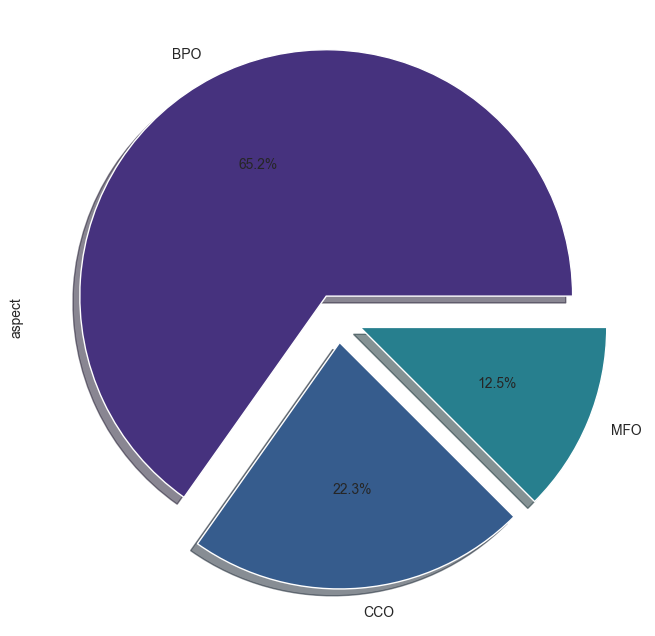

In [114]:
fig, ax = plt.subplots(figsize=(12, 8))

train_terms['aspect'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax, explode=[0.1, 0.1, 0.1], shadow=True)
plt.show()

- **65.2%** GO terms fall under Biological Process (BPO)
- **22.3%** GO terms fall under Cellular Component (CCO)
- Only **12.5%** GO terms fall under Molecular Function (MFO)

Let us plot the **100 most frequent** GO terms.

In [115]:
import plotly.express as px

In [116]:
term_vcs_100 = term_vcs[:100]

fig = px.bar(term_vcs_100,
             labels={
                 "index": "GO term",
                 "value": "Count",
             },
            title="100 most frequent GO terms")
fig.show()

Since, there are $31466$ GO terms in total. To reduce the complexity and training time, we will select only the $2000$ most frequent GO terms from the dataset for the DNN model to be trained on.

# T5 protein embeds

<br>

Let us look at the **protein IDs** and their **embeddings**.

In [117]:
train_ids = np.load("kaggle/input/t5embeds/train_ids.npy")
train_embeds = np.load("kaggle/input/t5embeds/train_embeds.npy")

In [118]:
print("Train ids shape: ", train_ids.shape)
print("Train embeds shape: ", train_embeds.shape)

Train ids shape:  (142246,)
Train embeds shape:  (142246, 1024)


Each protein is embedded into a vector of size $1024$ as represented by the number of columns of `train_embeds`.

In [119]:
train_ids

array(['P20536', 'O73864', 'O95231', ..., 'Q5RGB0', 'A0A2R8QMZ5',
       'A0A8I6GHU0'], dtype='<U10')

In [120]:
train_embeds

array([[ 0.04948843, -0.03293516,  0.03247323, ..., -0.04353154,
         0.0964628 ,  0.07306959],
       [-0.04461636,  0.06492499, -0.08026284, ...,  0.02672353,
         0.02787905, -0.04842958],
       [-0.02012804, -0.04977943,  0.00789446, ..., -0.03610279,
         0.00769301,  0.10623412],
       ...,
       [ 0.01691809,  0.04133058,  0.00079253, ...,  0.0088079 ,
         0.00648063, -0.01334958],
       [ 0.06125151,  0.08340203,  0.0440247 , ...,  0.00138361,
        -0.04754627,  0.01012351],
       [ 0.02160021,  0.06516985,  0.07492343, ...,  0.0496657 ,
        -0.01987522,  0.04471432]])

Now, let us check whether the protein IDs in `train_ids` and the protein IDs in `train_terms.tsv` are actually same or not.

In [121]:
entry_ids = train_terms['EntryID'].unique()

train_ids.shape == entry_ids.shape

True

In [122]:
train_ids_sorted = np.sort(train_ids)
entry_ids_sorted = np.sort(entry_ids)

Sort for better comparison speed...

In [123]:
print("T5 ids and entry ids are equal?", np.array_equal(train_ids_sorted, entry_ids_sorted))

T5 ids and entry ids are equal? True


Let us look at each protein ID and its embedding individually...

In [124]:
for i, v in enumerate(train_ids[:10]):
    print("Protein Entry id: ", v)
    print("Embed: ", train_embeds[i])

Protein Entry id:  P20536
Embed:  [ 0.04948843 -0.03293516  0.03247323 ... -0.04353154  0.0964628
  0.07306959]
Protein Entry id:  O73864
Embed:  [-0.04461636  0.06492499 -0.08026284 ...  0.02672353  0.02787905
 -0.04842958]
Protein Entry id:  O95231
Embed:  [-0.02012804 -0.04977943  0.00789446 ... -0.03610279  0.00769301
  0.10623412]
Protein Entry id:  A0A0B4J1F4
Embed:  [-0.00751462  0.06062775  0.00404452 ... -0.01835678  0.00808748
  0.01091709]
Protein Entry id:  P54366
Embed:  [ 0.01346817  0.04151568  0.01843523 ... -0.01686103 -0.01627228
  0.03705433]
Protein Entry id:  P33681
Embed:  [ 0.00111665 -0.01536268  0.04287748 ... -0.01112879  0.083754
  0.0339335 ]
Protein Entry id:  P77596
Embed:  [0.0367878  0.05298005 0.03909933 ... 0.01712867 0.03396751 0.02492985]
Protein Entry id:  Q16787
Embed:  [ 0.00710834  0.01562744  0.0743786  ...  0.02550209  0.05128309
 -0.01654935]
Protein Entry id:  Q59VP0
Embed:  [-0.00610487 -0.02672018  0.03133268 ... -0.03795149 -0.01819873
  0

<div style="border-radius: 10px; background-color: #0077B6">
    <h1 style="color: white; padding: 1rem">Preparing the Data</h1>
</div>

<br>

As mentioned above, we will select only the $2000$ most frequent GO terms as labels, to reduce training time and *dimensionality*.

Discarding the other rows from `train_terms.tsv`...

In [125]:
NUM_LABELS = 2000

terms_2k = term_vcs.index[:NUM_LABELS].tolist()
for t in terms_2k[:10]:
    print(t, end=", ")

GO:0005575, GO:0008150, GO:0110165, GO:0003674, GO:0005622, GO:0009987, GO:0043226, GO:0043229, GO:0005488, GO:0043227, 

Retreive the appropriate `train_terms data` from the `terms_2k` list.

In [126]:
train_terms_2k = train_terms.loc[train_terms['term'].isin(terms_2k)]
train_terms_2k

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO
6,A0A009IHW8,GO:0044237,BPO
...,...,...,...
5363857,X5L565,GO:0003674,MFO
5363859,X5L565,GO:0016491,MFO
5363860,X5M5N0,GO:0005515,MFO
5363861,X5M5N0,GO:0005488,MFO


<h1 style="color: darkblue">Processing steps</h1>

Any protein (train id) can have multiple GO terms associated to it. So, this is a **Multi-label Classification** task.

We have a `DataFrame` of train/protein ids (essentially, their embeddings) of shape $(N, 1024)$ as the training data. Here, $N$ is the number of train/protein ids. The labels for this **supervised** task will be of shape $(N, 2000)$.

The columns stand for the most frequent $2000$ GO terms. A cell $(i,\space j)$ in `labels` can have values either `0` or `1` representing whether the $j^{th}$ GO term is associated with the $i^{th}$ train/protein id or not.

To prepare the `labels` we need to perform the following steps...

1. **Iterate through the $2000$ labels**
2. **Find all the rows in `train_terms` containing that GO term**
3. **Get the unique `EntryID`s of those rows in `train_terms` from step 2**
4. **Replace the `ith` column of `labels` with $1.0$ if GO term belongs to that protein else $0.0$**

In [127]:
# initialize empty labels array
labels_shape = (train_ids.shape[0], NUM_LABELS)
labels = np.empty(labels_shape)

In [128]:
# progress bar
from tqdm import tqdm

> For large datasets, pandas `isin` works better than numpy's `isin`

In [129]:
series_train_ids = pd.Series(train_ids)

with tqdm(total=NUM_LABELS) as pbar:
    # Step 1
    for i in range(NUM_LABELS):
        go_term = terms_2k[i]
        
        # Step 2 
        curr_train_terms = train_terms_2k[train_terms_2k['term'] == go_term]
        
        # Step 3
        uniq_entry_ids = curr_train_terms['EntryID'].unique()
        
        # Step 4
        labels[:, i] = series_train_ids.isin(uniq_entry_ids).astype(float)
        
        pbar.update(1)

100%|██████████| 2000/2000 [04:41<00:00,  7.11it/s]


Got our labels, creating a `DataFrame`...

In [130]:
labels_df = pd.DataFrame(labels, columns=terms_2k)

In [131]:
labels_df

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0032368,GO:0046660,GO:0009247,GO:0008582,GO:0035967,GO:0043197,GO:0016101,GO:0005746,GO:0050866,GO:0008589
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142242,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142243,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142244,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
train_df = pd.DataFrame(train_embeds, columns=[f"col{i+1}" for i in range(train_embeds.shape[1])])

In [133]:
train_df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col1015,col1016,col1017,col1018,col1019,col1020,col1021,col1022,col1023,col1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


There we have it:

- `train_df`: Our DNN model ready training data. Shape: $(N, 1024)$
- `labels_df`: Our DNN model ready labels for the multi-label classification task. Shape: $(N, 2000)$

<div style="border-radius: 10px; background-color: #0077B6">
    <h1 style="color: white; padding: 1rem">Building and Training the DNN model</h1>
</div>

Now is the time to build our DNN model using `Tensorflow Keras`.

I will use the below model configuration:

- **Input Layer, $1024$ neurons**
- **Batch Normalization Layer**
- **$10$ Hidden Layers, $300$ neurons each having:**
    - Kernel Initialization: `He normal`
    - Batch Normalization layer
    - Leaky ReLU activation layer
- **Output Layer, $2000$ neurons:**
    - Sigmoid activation function

Along with this, I will use the loss function `binary_crossentropy` for multi-label classification, and `ADAM` optimizer.

In [134]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

[]

The input shape in this case will be $1024$.

In [135]:
INPUT_SHAPE = [train_df.shape[1]]

In order to write error-prone code, I will use the `partial` function to define a thin wrapper for each of the **Hidden Layers**.

In [136]:
from functools import partial

Next, writing a function to create and return a model with the above structure...

In [137]:
# LeakyReLU alpha
alpha = 0.1

NUM_HIDDEN_LAYERS = 10

# Function to create a sequential keras DNN model
def create_model(inp_shape):
    m = tf.keras.Sequential()
    
    # 1 and 2) Input layer and BatchNorm layer
    m.add(tf.keras.layers.BatchNormalization(input_shape=inp_shape))
    
    # Wrapper for the hidden layers
    DenseLayer = partial(
        tf.keras.layers.Dense,
        kernel_initializer="he_normal",
        use_bias=False
    )
    
    # 3) 10 Hidden Layers
    for _ in range(NUM_HIDDEN_LAYERS):
        m.add(DenseLayer(300))
        m.add(tf.keras.layers.BatchNormalization())
        m.add(tf.keras.layers.LeakyReLU(alpha=alpha))
        
    # 4) output layer
    m.add(tf.keras.layers.Dense(NUM_LABELS, activation="sigmoid"))
    
    return m

To ensure an optimal model performance, we need a **Validation set** to evaluate the model on, after each epoch.

In [138]:
# train and validation set
from sklearn.model_selection import train_test_split

X = train_df.to_numpy()
y = labels_df.to_numpy()

In [139]:
print(X.shape, y.shape)

(142246, 1024) (142246, 2000)


We will keep $80$% of the dataset for training, and $20$% for validation...

In [140]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(113796, 1024) (28450, 1024)
(113796, 2000) (28450, 2000)


Create a new model with the appropriate input shape...

In [141]:
new_model = create_model(inp_shape=[X_train.shape[1]])

c:\Users\blloy\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

c:\Users\blloy\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



In [142]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       307,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │        90,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │        90,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │        90,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │        90,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 300)            │        90,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │        90,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │             

 Total params: 1,735,296 (6.62 MB)

 Trainable params: 1,727,248 (6.59 MB)

 Non-trainable params: 8,048 (31.44 KB)

$1.7M$ parameters in total. Hmm, nice!

Compiling the model to calculate `binary_accuracy` and `AUC (Area Under the Curve)` as evaluation metrics.

In [143]:
# compile model with ADAM
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

While training a DNN model, we can define some **callback functions** that are performed after each epoch (by default).

I will use two callbacks:

- **Early Stopping Callback**: This will monitor the `loss` of the model and will stop training if it doesn't change for $10$ epochs.
- **Model Checkpoint Callback**: This will save the best model on the disk for persistence.

In [147]:
# callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "kaggle/working/best_model.weights.h5", save_best_only=True, save_weights_only=True
)


# checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("kaggle/working/best_model.h5", save_best_only=True)

In [164]:
# train new model
history = new_model.fit(X_train, y_train, epochs=30,
                       validation_data=(X_val, y_val),
                       callbacks=[earlystopping_cb, checkpoint_cb])

new_model.predict()

Epoch 1/30
 633/3557 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - auc: 0.9586 - binary_accuracy: 0.9866 - loss: 0.0406

KeyboardInterrupt: 

A validation accuracy of $0.985$. Nice! 

The `history.history` variable contains the information of each epoch.

In [160]:
history_df = pd.DataFrame(history.history)
history_df.head()

,auc,binary_accuracy,loss,val_auc,val_binary_accuracy,val_loss
0,0.899318,0.984324,0.056677,0.916751,0.984834,0.051978
1,0.919553,0.984975,0.051495,0.925609,0.985151,0.049897
2,0.925470,0.985102,0.050228,0.927970,0.985283,0.049106
3,0.929397,0.985200,0.049289,0.932275,0.985225,0.048817
4,0.932535,0.985281,0.048532,0.934616,0.985409,0.047954


Plotting the training loss and accuracy along with validation loss and accuracy...

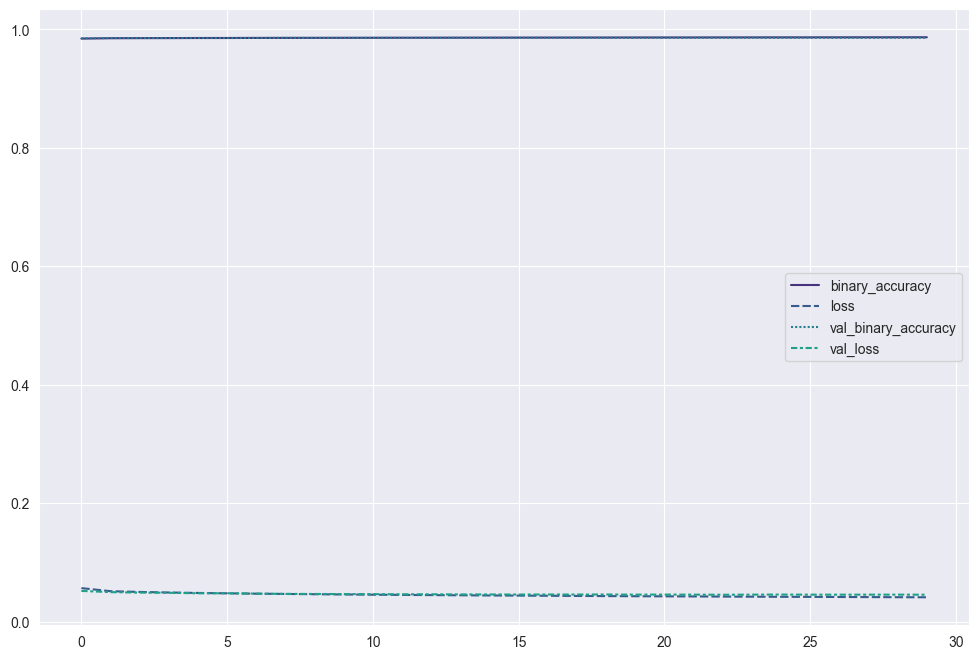

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(history_df.drop(columns=["auc", "val_auc"]))
plt.show()

This seems to perform well!

**Hyperparameter tuning** and be further performed on this model for even better results. Below is the full model architecture.

In [162]:
img_file = 'kaggle/working/model_arch.png'

tf.keras.utils.plot_model(new_model, to_file=img_file, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


<div style="border-radius: 10px; background-color: #0077B6">
    <h1 style="color: white; padding: 1rem">Conclusion</h1>
</div>

<br>

This was all about the **CAFA 5 Protein** dataset and how DNN models can be effectively used in the biological field to predict the *function* of various proteins, in order to understand the biological systems more thoroughly.

**<span style="color: darkblue">If this notebook helped you a slightest bit, do consider upvoting it and leaving a comment below. Feel free to extend this notebook with more knowledge. Thank you! ❤️</span>**